In [177]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import joblib

np.random.seed(69)
figsize = (12, 6)

In [2]:
TRAIN, VAL, TEST = .7, .2, .1

In [3]:
cl = pd.read_csv('./clean_data/cl.csv',index_col=0)
cl.index = pd.to_datetime(cl.index)

In [4]:
cl

,CL1,CL2,CL3,CL4,CL5,CL6,CL7,CL8,CL9,CL10,CL11,CL12,CL13,CL14,CL15
date,,,,,,,,,,,,,,,
2000-01-04,95.815628,41.908697,22.341416,16.819990,13.364847,11.499828,10.689387,10.208021,9.741887,9.556244,9.424994,9.415127,9.254053,9.267592,9.395099
2000-01-05,93.415550,40.879538,21.850701,16.583088,13.294475,11.479136,10.640331,10.141302,9.677218,9.556244,9.365226,9.266271,9.101361,9.108371,9.232039
2000-01-06,92.928034,40.828924,21.795148,16.453870,13.100951,11.287730,10.493162,10.022160,9.561738,9.376806,9.245689,9.233709,9.068972,9.075590,9.198468
2000-01-07,90.827965,40.086580,21.526644,16.331829,13.059901,11.272211,10.488256,10.031692,9.580215,9.409012,9.282470,9.280226,9.129123,9.145835,9.279998
2000-01-10,92.515520,40.710823,21.869219,16.604625,13.276882,11.468789,10.674670,10.127005,9.654122,9.478027,9.356031,9.280226,9.129123,9.178616,9.279998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-24,77.720000,77.230000,76.710000,76.130000,75.600000,75.090000,74.620000,74.170000,73.750000,73.370000,73.010000,72.670000,72.320000,71.980000,71.670000
2024-05-28,79.830000,79.350000,78.830000,78.240000,77.670000,77.140000,76.620000,76.120000,75.670000,75.240000,74.840000,74.460000,74.060000,73.670000,73.310000
2024-05-29,79.230000,78.800000,78.340000,77.810000,77.280000,76.770000,76.290000,75.810000,75.380000,74.960000,74.560000,74.170000,73.760000,73.380000,73.020000


In [5]:
ho = pd.read_csv('./clean_data/ho.csv',index_col=0)
ho.index = pd.to_datetime(ho.index)

In [6]:
r_ho = ho.pct_change().dropna()

In [7]:
r_cl = cl.pct_change().dropna()

In [8]:
_rets = pd.concat([r_ho, r_cl], axis=1)

In [9]:
dates = _rets.index
n_days = len(dates)
print(n_days)

6131


In [10]:
train_size, val_size, test_size = int(TRAIN * n_days), int(VAL * n_days), int(TEST * n_days)
train_dates, val_dates, test_dates = dates[:train_size], dates[train_size:train_size+val_size], dates[-test_size:]

In [11]:
rets = _rets.loc[train_dates]

<AxesSubplot:>

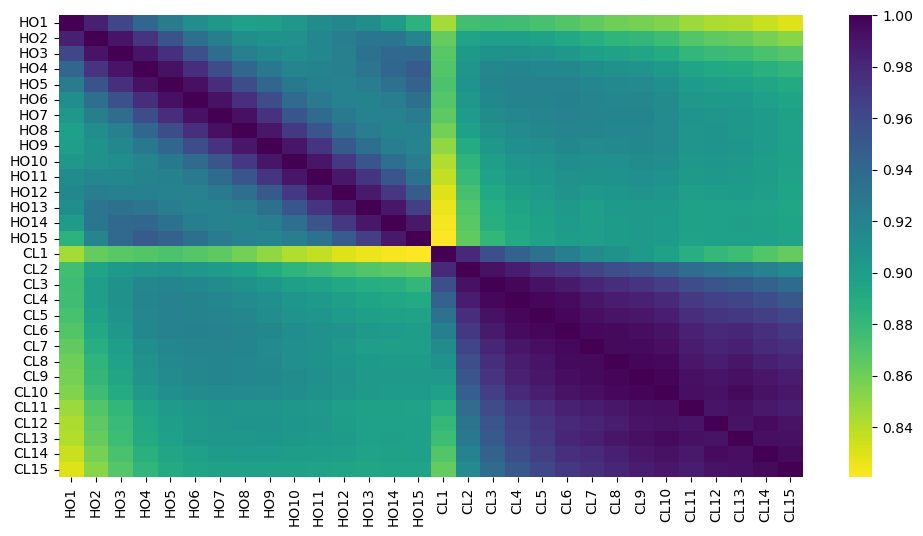

In [12]:
fig = plt.figure(figsize=(12,6))
sns.heatmap(rets.corr(), cmap='viridis_r')

In [13]:
corr = rets.corr()

In [14]:
evals, evecs = np.linalg.eig(corr)
evecs = evecs.T

idx = np.argsort(evals)[::-1]
evals, evecs = evals[idx], evecs[idx]

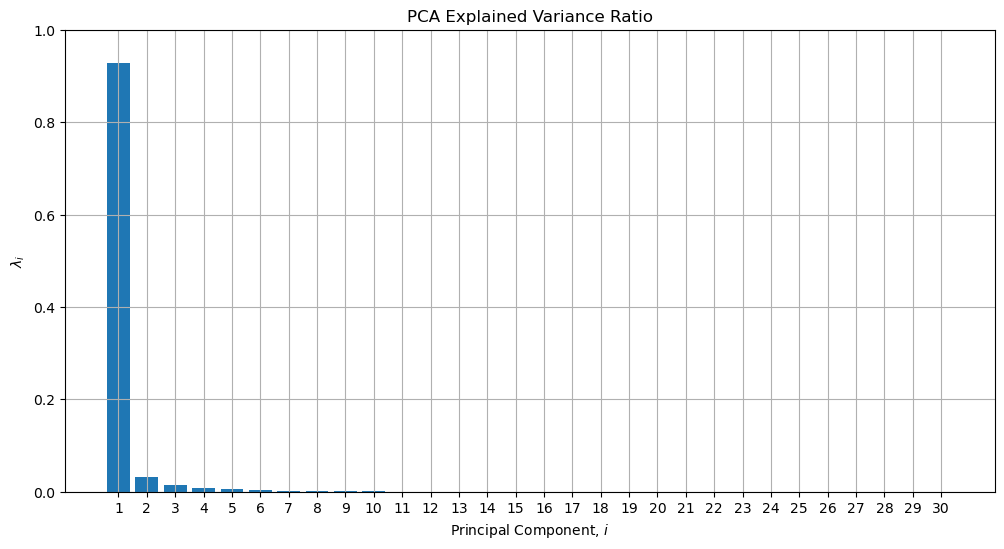

In [24]:
plt.figure(figsize=figsize)
plt.bar(np.arange(1, len(evals)+1), evals / len(evals))
plt.title("PCA Explained Variance Ratio")
plt.xlabel(r"Principal Component, $i$"); plt.ylabel(r"$\lambda_i$")
plt.grid(True); plt.ylim(0, 1)
_ = plt.xticks(np.arange(1, len(evals)+1))

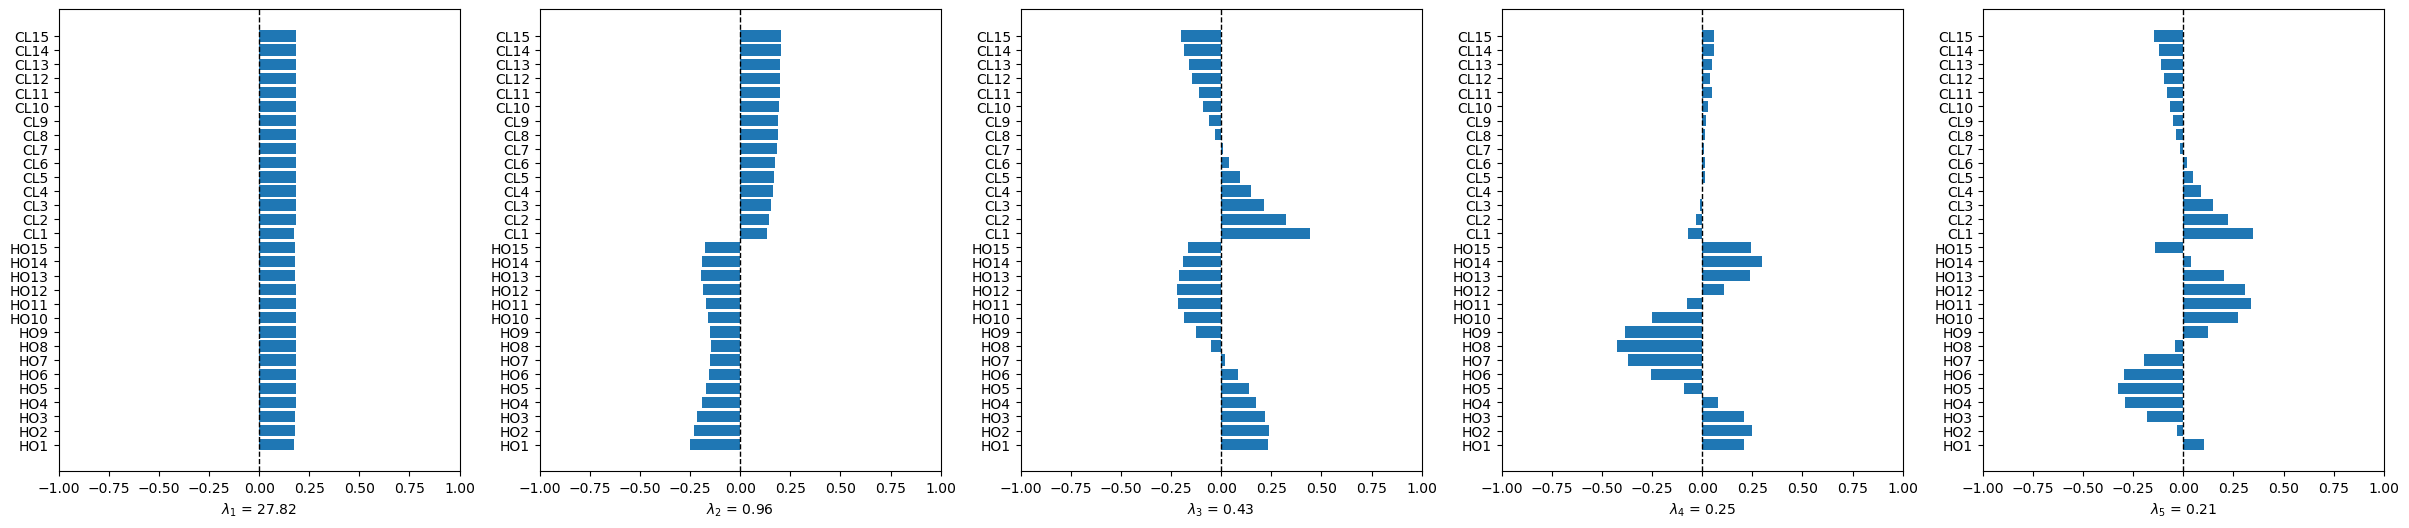

In [25]:
fig, axs = plt.subplots(1, 5, figsize=(30, 6))

for i, ax in enumerate(axs):
    ax.barh(np.arange(1, len(evals)+1), evecs[i])#, alpha=evals[i] / evals.sum())
    ax.set_xlim(-1, 1)
    ax.set_yticks(np.arange(1, len(evals)+1))
    ax.set_yticklabels(rets.columns)
    ax.axvline(0, ls='--', lw=1, color='black')
    ax.set_xlabel(f"$\lambda_{{{i+1}}}$ = {evals[i]:.2f}")

plt.show()

In [26]:
n_factors = 3
factors = np.arange(n_factors)

### Eigenportfolios

i.e., rows of `evecs`

Some math to avoid confusion:
* $r_i \in  \mathbb{R}^N$: vector of asset returns - row of `rets`, indexed by asset names
* $\Omega \in \mathbb{R}^{NxN}$: correlation matrix of the returns - `corr` in the program
* $\Lambda = \text{diag}(\lambda_i, \dots, \lambda_n) \in \mathbb{R}^{N x N}$: diagonal matrix of the eigenvalues `evals`
* $B \in \mathbb{R}^{NxN}$: matrix of eigenvectors, such that $B\Lambda B^T = \Omega$
    - NOTE 1: it corresponds to `evecs.T` (or, equivalently, `evecs` corresponds to $B^T$)
    - NOTE 2: in `eigen_port`, it gets normalized such that every eigenvector has a GMV (1-norm) of $1
    
* $\beta_j \in \mathbb{R}^N$: j-th principal component (loading for each asset) or column of $B$ - given by `evecs[j]` (NOT `evecs[:, j]`)
* $\beta_j'$: inverse of the $j$-th principal component, i.e., $j$-th row of $B$ - `evecs[:, j]`
* Exposure matrix is thus given by $X\in \mathbb{R}^{Nxp} = col(B)_{j=1,\dots,p}$ - `evecs[:p].T`
* $r_{PC} = \left[\beta_j^Tr_i\right]_{j=1,\dots,p} \in \mathbb{R}^p$: projected returns onto the $j$-th principal component - row of `eigen_rets`, indexed by PC number
* The model is:
$$
\hat{r}_i \, = \, Xr_{PC} + \epsilon_i
$$
or, in code, `evecs[:p].T @ eigen_rets.iloc[i, :p] = rets.iloc[i] + resid.iloc[i]`, which gives an easy formulafor estimating the residuals

VERY IMPORTANT: Note in particular that `eigen_rets.iloc[i, :p] = np.linalg.solve((evecs[:p] @ evecs[:p].T), (evecs[:p] @ rets.iloc[i]))`, the OLS soution to the model.

In [35]:
eigen_port = evecs / (np.abs(evecs).sum(axis=1)[:, None])

In [36]:
eigen_rets = rets @ evecs.T
eigenport_rets = rets @ eigen_port.T
# eigen_rets = rets @ evecs.T <=> rets = eigen_rets @ evecs

In [39]:
eigen_port.shape

(30, 30)

<AxesSubplot:xlabel='date'>

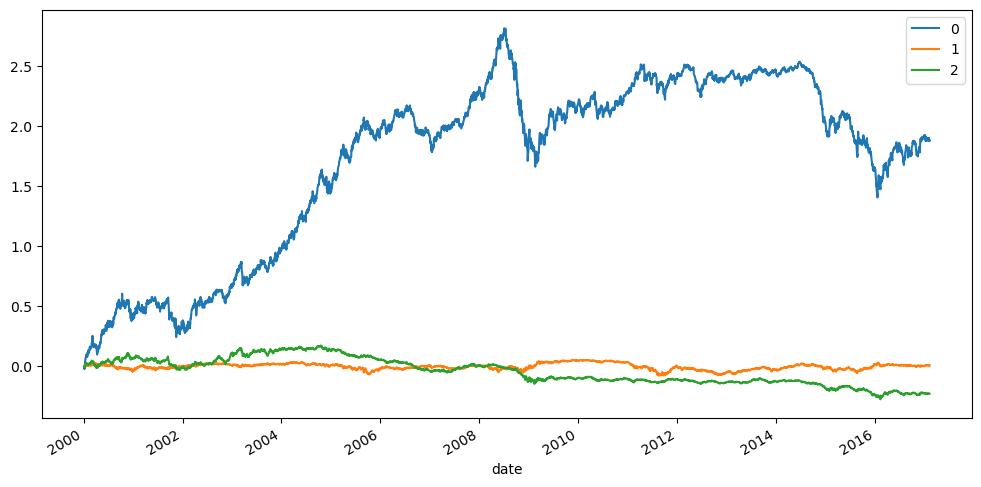

In [96]:
eigenport_rets[factors].cumsum().plot(figsize=(12, 6))

<AxesSubplot:xlabel='date'>

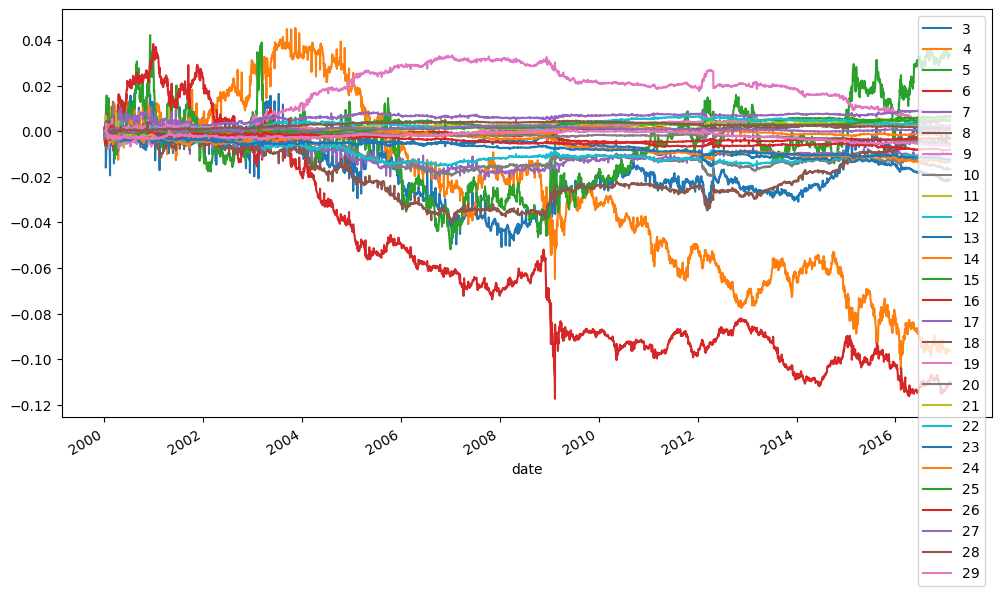

In [97]:
eigenport_rets.iloc[:, 3:].cumsum().plot(figsize=(12, 6))

In [61]:
def get_fitted_and_residuali(n_fac):
    fitted = eigen_rets.iloc[:, :n_fac] @ evecs[:n_fac]    
    fitted = fitted.set_axis(rets.columns, axis=1)
    resid = rets - fitted
    return fitted, resid


def plot_rolling_stats(df, ax):
    avg = df.rolling(90, center=False).mean()
    std = df.rolling(90, center=False).std()
    ax2 = ax.twinx()
    ax.plot(avg)
    ax2.plot(std)

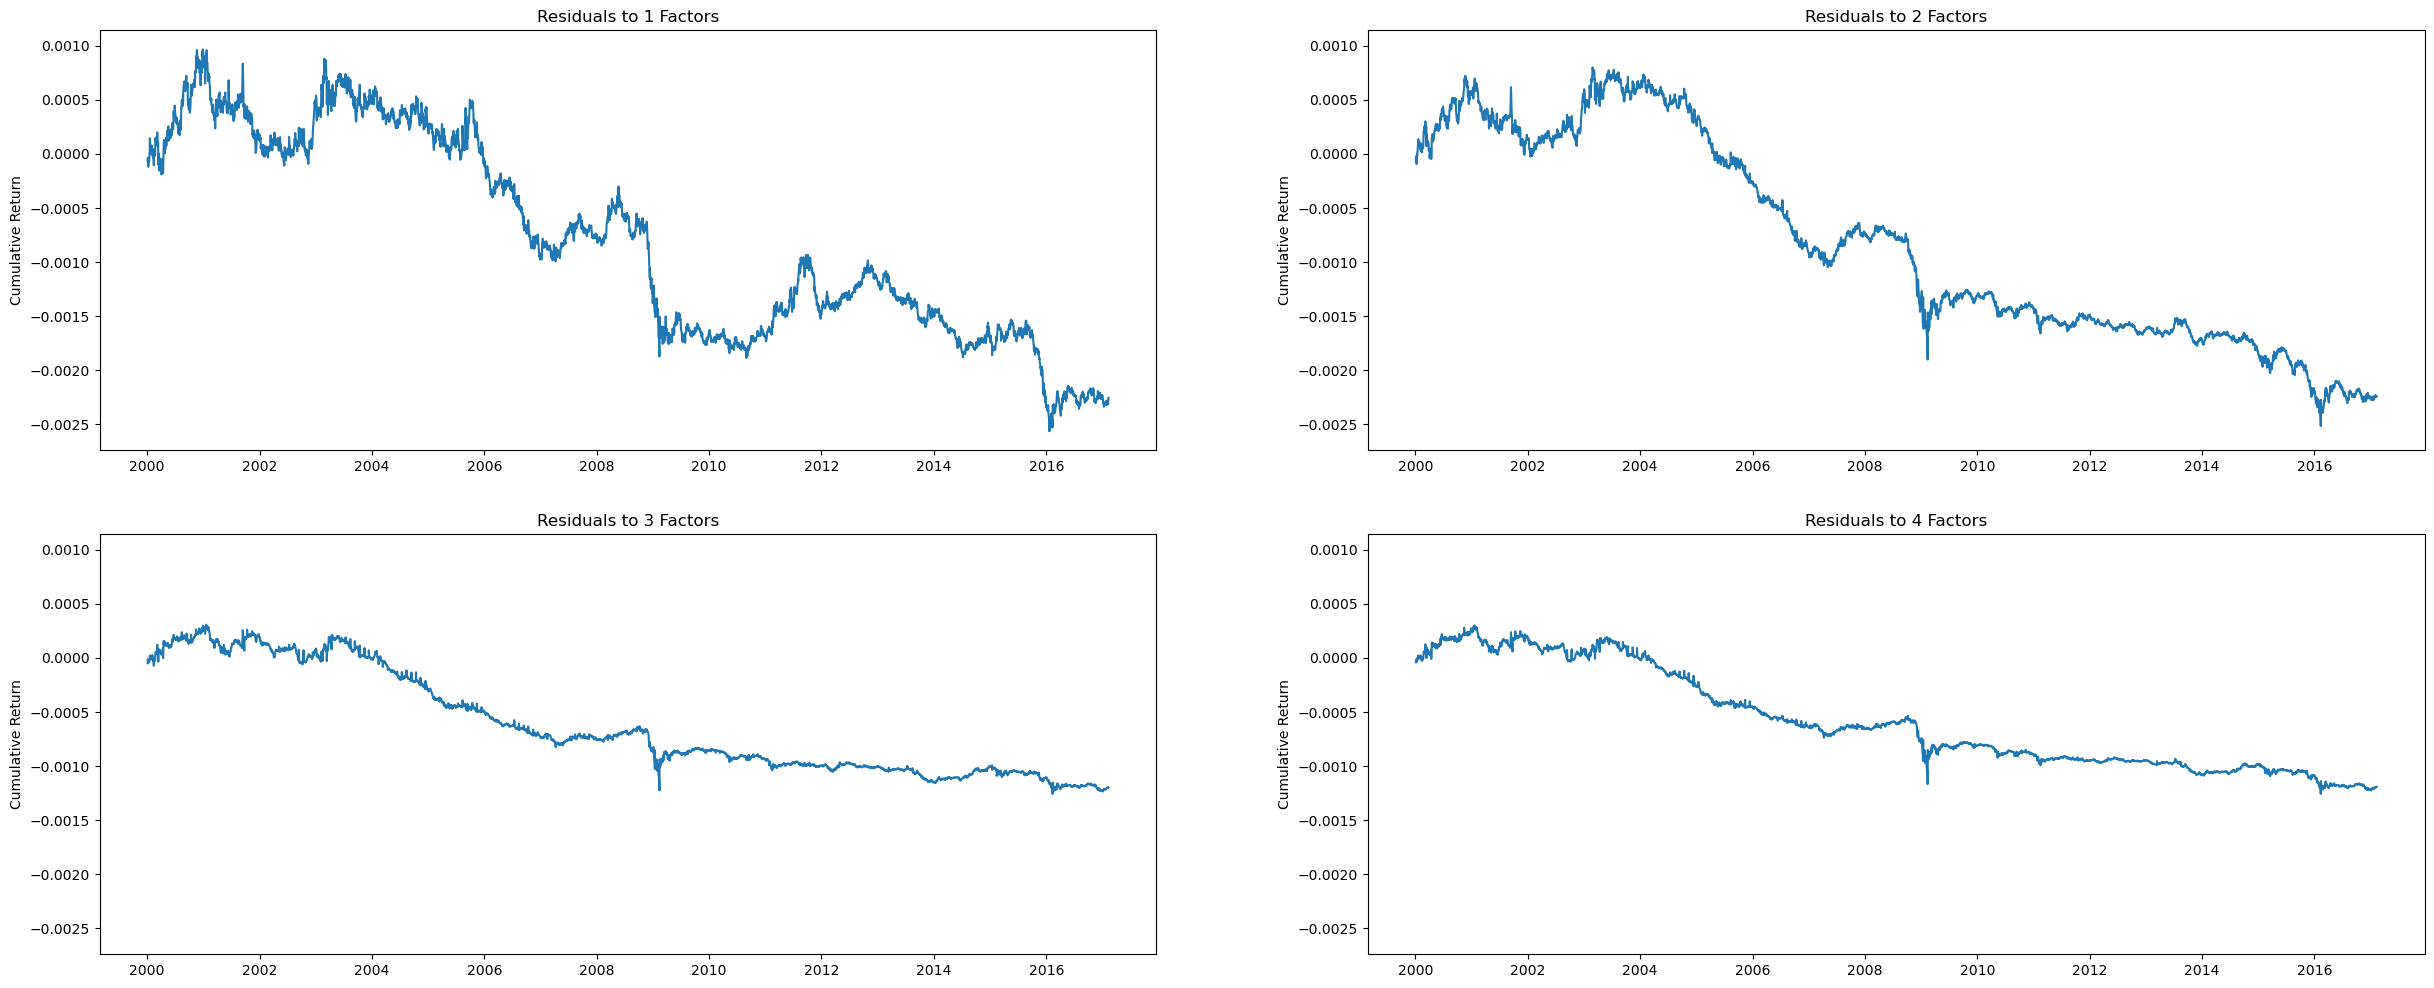

In [44]:
fig, axs = plt.subplots(2, 2, figsize=(30, 12))
axs = axs.flatten()

for i, ax in enumerate(axs):
    _, r = get_fitted_and_residuali(i+1)
    ax.plot(r.mean(axis=1).cumsum())
    # ax.plot(r.mean(axis=1).abs().cumsum())
    ax.set_title(f'Residuals to {i+1} Factors')
    ax.set_ylabel('Cumulative Return')
for ax in axs:
    ax.set_ylim(min(a.get_ylim()[0] for a in axs),max(a.get_ylim()[1] for a in axs))

plt.show()

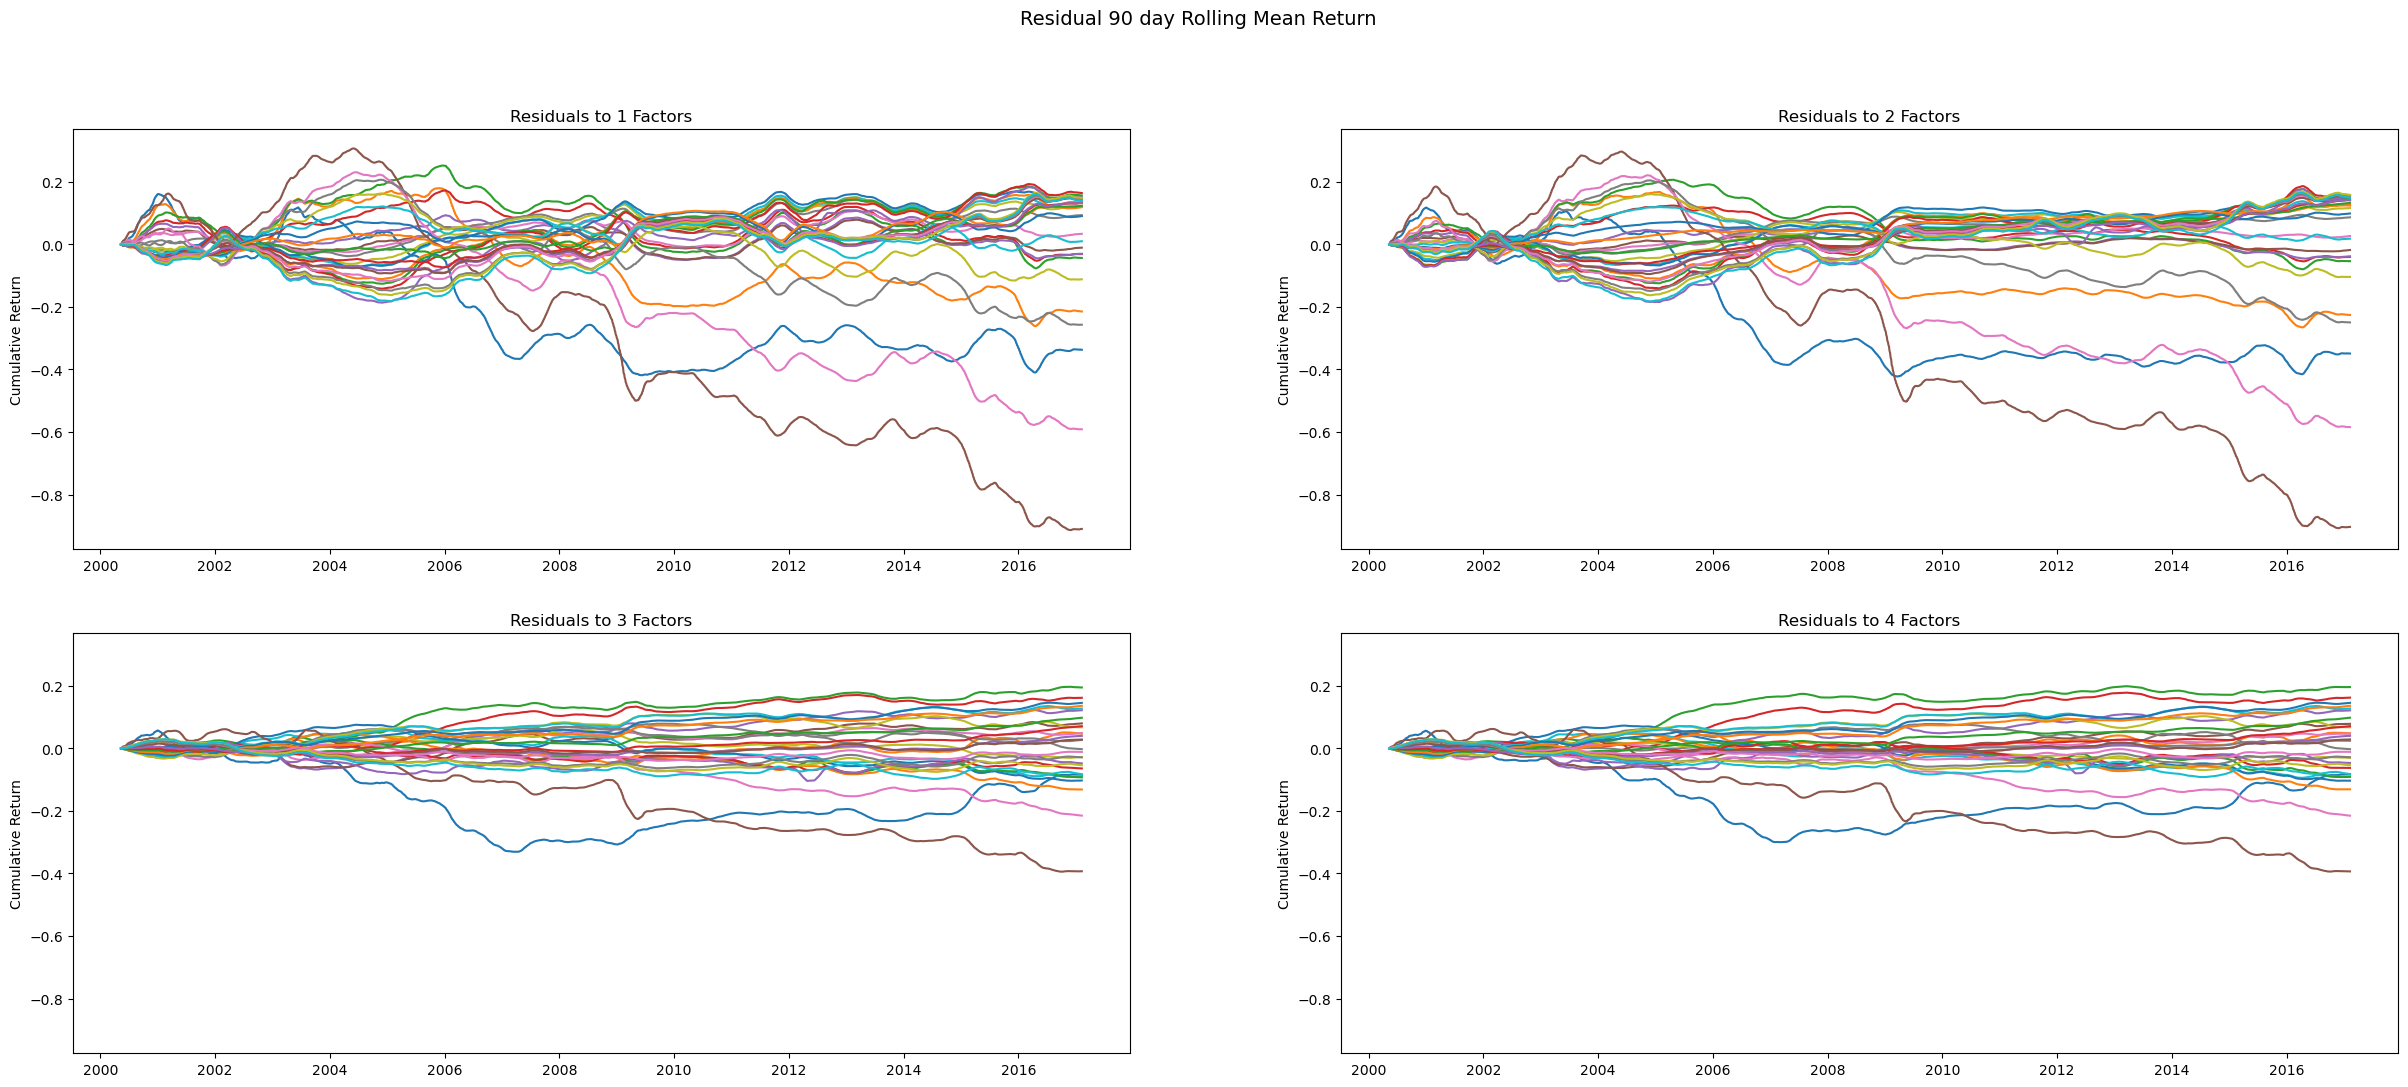

In [45]:
fig, axs = plt.subplots(2, 2, figsize=(30, 12))
axs = axs.flatten()
fig.suptitle(f"Residual 90 day Rolling Mean Return", fontsize=14)

for i, ax in enumerate(axs):
    _, r = get_fitted_and_residuali(i+1)
    ax.plot(r.rolling(90).mean().cumsum())
    ax.set_title(f'Residuals to {i+1} Factors')
    ax.set_ylabel('Cumulative Return')
for ax in axs:
    ax.set_ylim(min(a.get_ylim()[0] for a in axs),max(a.get_ylim()[1] for a in axs))

plt.show()

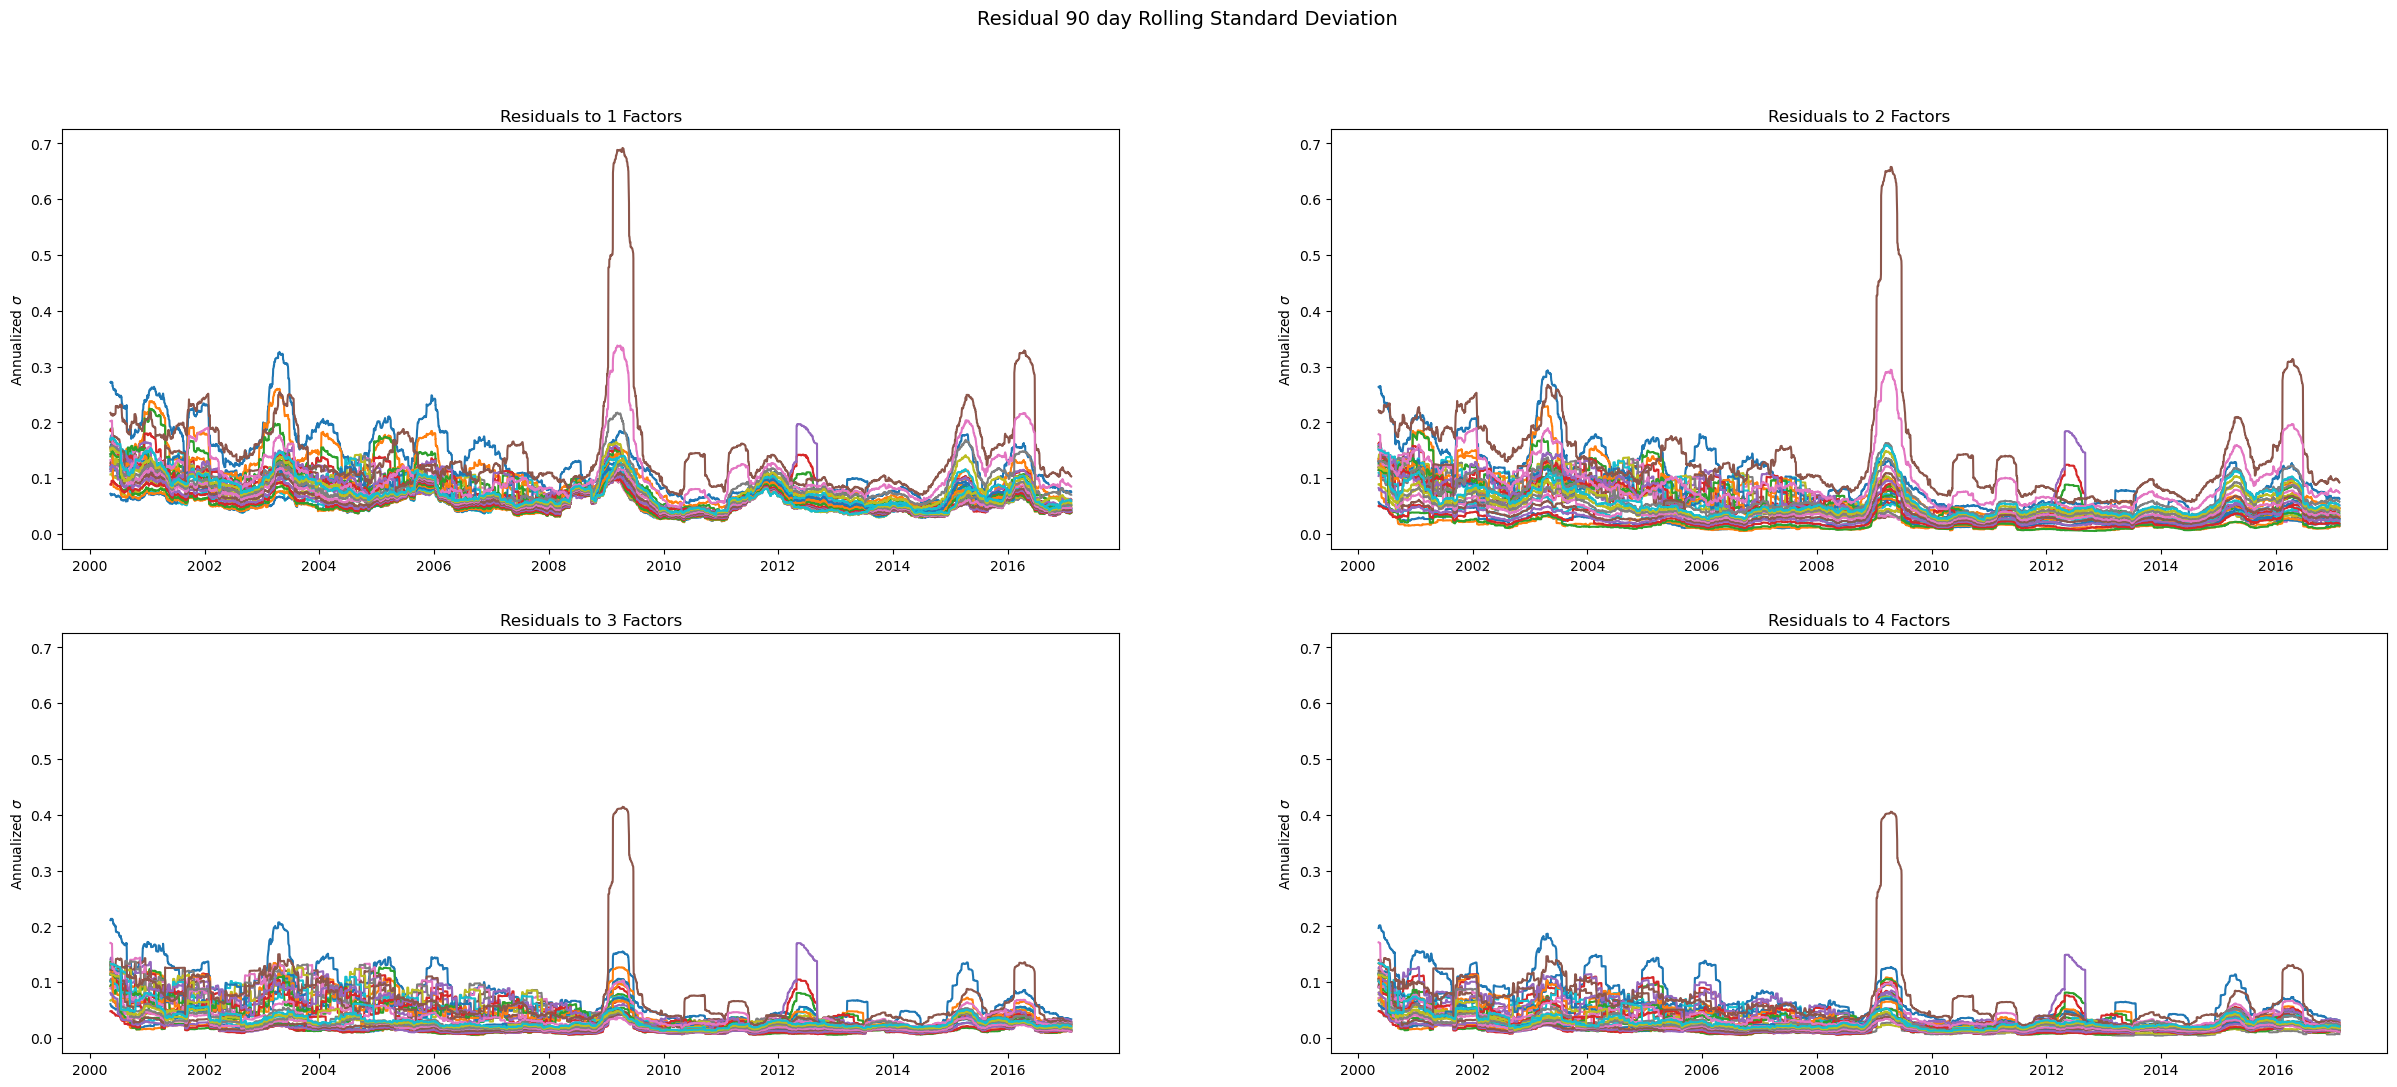

In [47]:
fig, axs = plt.subplots(2, 2, figsize=(30, 12))
axs = axs.flatten()
fig.suptitle(f"Residual 90 day Rolling Standard Deviation", fontsize=14)

for i, ax in enumerate(axs):
    _, r = get_fitted_and_residuali(i+1)
    ax.plot(r.rolling(90).std() * 252**0.5)
    ax.set_title(f'Residuals to {i+1} Factors')
    ax.set_ylabel(r'Annualized $\sigma$')
for ax in axs:
    ax.set_ylim(min(a.get_ylim()[0] for a in axs),max(a.get_ylim()[1] for a in axs))

plt.show()

In [98]:
_, resid = get_fitted_and_residuali(3)

In [102]:
exp = evecs[:3].T

# Rete Neurale Convoluzionale

(RNC)

In [103]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

torch.manual_seed(1)

In [104]:
n_assets = resid.shape[1]
n_contracts = 15
n_comm = n_assets // n_contracts
seq_length = 21

In [106]:
resid.head()

,HO1,HO2,HO3,HO4,HO5,HO6,HO7,HO8,HO9,HO10,...,CL6,CL7,CL8,CL9,CL10,CL11,CL12,CL13,CL14,CL15
date,,,,,,,,,,,,,,,,,,,,,
2000-01-05,-0.004020,-0.002701,0.001954,0.001776,0.003465,0.004303,0.004245,0.010820,0.009820,-0.005041,...,0.010515,0.007257,0.004808,0.004287,0.010536,0.003819,-0.006144,-0.007019,-0.008075,-0.008517
2000-01-06,0.007325,0.004951,-0.000860,-0.001378,-0.003530,-0.004570,-0.005361,-0.012415,-0.011980,0.003178,...,-0.007407,-0.004519,-0.002330,-0.002408,-0.009207,-0.003231,0.006158,0.006132,0.006140,0.006115
2000-01-07,-0.003362,-0.001803,-0.000803,0.000144,0.001857,0.003224,0.001629,-0.001008,0.000711,0.002637,...,0.001504,0.000637,0.000154,-0.000434,-0.000340,-0.001020,-0.001645,-0.000775,-0.000914,-0.000629
2000-01-10,-0.016000,-0.012820,-0.006710,-0.000735,0.001910,0.004467,0.006021,0.006469,0.002501,-0.001151,...,0.006527,0.007200,-0.000755,-0.002294,-0.002407,-0.001515,-0.009183,-0.009046,-0.005226,-0.008631
2000-01-11,0.002405,0.002313,0.002454,0.001294,0.000835,-0.000530,-0.001791,-0.001322,-0.000616,-0.000027,...,-0.006902,-0.007125,0.000835,0.002037,0.001655,0.000184,0.007682,0.006318,0.001067,0.002946


In [107]:
print("frog", "plane", "deer", "car")

frog plane deer car


In [108]:
class RNC(nn.Module):
    def __init__(self,
                 activation,
                 seq_length = 21,
                 in_channels = 1,
                 out_channels = 2,
                 hidden_size = 32,
                 kernel_size = (1, 15),
                 stride = (1, 15),
                 padding = 0):
        super().__init__()
        self._activation = activation
        # first convolution - aggregate contracts for same comm
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size,
            stride=stride, padding=padding
        )
        self.fc1 = nn.Linear(seq_length * out_channels * n_comm, hidden_size)
        self.fc2 = nn.Linear(hidden_size, n_assets)

    def forward(self, x):
        x = self._activation(self.conv1(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self._activation(self.fc1(x))
        x = self.fc2(x)
        return x

In [109]:
def load_data(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append([data[i+lookback]])
        
    X = torch.tensor(np.array(X), dtype=torch.float32).unsqueeze(1)
    y = torch.tensor(np.array(y), dtype=torch.float32)
    return X, y

batch_size x channels_in x heigth x width

In [111]:
# training set
X_train, y_train = load_data(resid.values, seq_length)

In [112]:
# validation set figa
eigen_rets = _rets.loc[val_dates] @ evecs.T

def get_fitted_and_residuali(n_fac):
    fitted = eigen_rets.iloc[:, :n_fac] @ evecs[:n_fac]    
    fitted = fitted.set_axis(rets.columns, axis=1)
    resid = _rets.loc[val_dates] - fitted
    return fitted, resid

_, resid = get_fitted_and_residuali(3)
X_val, y_val = load_data(resid.values, seq_length)

In [113]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

torch.Size([4270, 1, 21, 30]) torch.Size([4270, 1, 30])
torch.Size([1205, 1, 21, 30]) torch.Size([1205, 1, 30])


### Training Loop

In [39]:
rete = RNC(activation=F.tanh, out_channels=5)

In [40]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(rete.parameters())

In [41]:
EPOCHS = 500
BATCH_SIZE = 32
loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE)

In [42]:
train_loss, val_loss = [], []

for e in range(EPOCHS):
    rete.train()
    for x_batch, y_batch in loader:
        y_hat = rete(x_batch)
        loss = loss_fn(y_hat, y_batch.squeeze(1))
        # optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # VALIDATION
    rete.eval()
    with torch.no_grad():
        # train loss:
        y_hat = rete(x_batch)
        loss = loss_fn(y_hat, y_batch.squeeze(1))
        train_loss.append(loss)
        # val loss:
        y_hat = rete(X_val)
        _val_loss = loss_fn(y_hat, y_val.squeeze(1))
        val_loss.append(_val_loss)
    if e % 50 == 0:
        print(f"Epoch: {e}\tTrain RMSE: {loss**0.5:.8f}\tVal RMSE: {_val_loss**0.5:.8f}")

Epoch: 0	Train RMSE: 0.00054510	Val RMSE: 0.00342339
Epoch: 50	Train RMSE: 0.00074940	Val RMSE: 0.00344544
Epoch: 100	Train RMSE: 0.00075165	Val RMSE: 0.00371401
Epoch: 150	Train RMSE: 0.00070948	Val RMSE: 0.00373687
Epoch: 200	Train RMSE: 0.00067707	Val RMSE: 0.00373667
Epoch: 250	Train RMSE: 0.00066156	Val RMSE: 0.00374072
Epoch: 300	Train RMSE: 0.00065199	Val RMSE: 0.00374206
Epoch: 350	Train RMSE: 0.00064239	Val RMSE: 0.00374109
Epoch: 400	Train RMSE: 0.00063710	Val RMSE: 0.00374171
Epoch: 450	Train RMSE: 0.00063225	Val RMSE: 0.00374528


In [109]:
torch.save(rete.state_dict(), './models/shittyCNN.pkl')

In [43]:
train_plot = np.array([x.item() for x in train_loss]).reshape(-1, 5).mean(axis=1)
val_plot = np.array([x.item() for x in val_loss]).reshape(-1, 5).mean(axis=1)

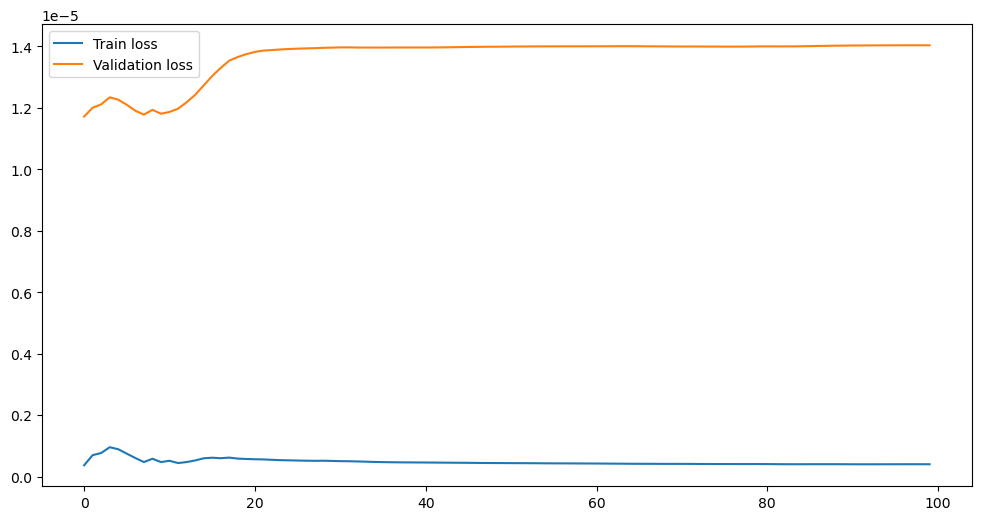

In [59]:
plt.figure(figsize=(12, 6))
plt.plot(train_plot, color='C0', label='Train loss')
plt.plot(val_plot, color='C1', label='Validation loss')
plt.legend()
plt.show()

#### Load checkpoint

In [117]:
rete = RNC(activation=F.tanh, out_channels=5)
rete.load_state_dict(torch.load('./models/shittyCNN.pkl'))

<All keys matched successfully>

In [119]:
y_hat = pd.DataFrame(rete(X_val).detach().numpy(), index=val_dates[seq_length:])
y_val = pd.DataFrame(y_val.squeeze(1).detach().numpy(), index=val_dates[seq_length:])

In [120]:
y_hat = y_hat.set_axis(rets.columns, axis=1)
y_val = y_val.set_axis(rets.columns, axis=1)

In [123]:
y_hat = y_hat.sub(y_hat.mean(axis=1), axis=0).div(y_hat.std(axis=1), axis=0)
y_hat

,HO1,HO2,HO3,HO4,HO5,HO6,HO7,HO8,HO9,HO10,...,CL6,CL7,CL8,CL9,CL10,CL11,CL12,CL13,CL14,CL15
date,,,,,,,,,,,,,,,,,,,,,
2017-03-13,2.453830,1.529431,0.649864,0.617491,-0.474870,-1.403369,-1.950699,-1.892773,-0.578204,0.556769,...,-0.703825,-0.618969,-0.503301,-0.243816,-0.144953,0.176838,0.019061,0.013620,0.344753,0.555005
2017-03-14,1.237320,-0.172663,0.220635,0.374224,0.486390,0.417990,0.768489,1.259628,2.209159,2.413879,...,0.119099,-0.176414,-0.566913,-0.307625,0.134328,-0.110627,-0.425495,-0.202617,-0.246175,0.194716
2017-03-15,2.374738,1.695880,0.658375,-0.365408,-1.204235,-1.450347,-1.693680,-1.857864,-1.551314,-0.998504,...,0.043460,-0.064447,0.066975,0.024309,0.079353,0.233431,-0.145595,0.175053,0.031519,0.296514
2017-03-16,-0.605204,-0.997688,-0.443412,1.201551,1.556878,1.379060,1.188569,1.767719,1.918783,1.565885,...,-0.512302,-0.540981,-0.075218,-0.300774,-0.405016,-0.339237,-0.079644,0.066687,-0.086400,0.040711
2017-03-17,1.184757,0.414702,0.806434,2.027161,1.503610,1.339022,0.881867,0.518854,0.601176,0.367662,...,-0.430831,-0.775850,0.330952,0.124430,0.179661,0.336652,-0.051444,0.761292,0.606519,0.536598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-14,1.302945,-0.117131,0.865942,2.044864,1.947802,1.773674,0.475800,-0.776952,-0.438433,-0.740900,...,0.517335,0.387798,0.432838,0.258903,0.355095,0.328982,-0.496565,0.687020,-0.042729,0.268656
2021-12-15,0.196190,1.602600,2.054324,1.512236,0.335739,-0.988824,-1.791989,-1.761658,-1.410901,-1.046004,...,0.098601,0.125203,0.217240,0.140482,0.028488,0.255067,-0.011171,0.198435,0.012690,0.251553
2021-12-16,2.986491,-0.256289,-1.521372,-0.924935,-0.975772,-0.266812,0.137532,0.474799,1.182655,1.667662,...,0.086578,-0.346646,-0.245688,-0.287502,0.048932,-0.685001,-0.784566,-0.177727,-0.207173,0.156113


Now the exposure matrix adds a column on each day `dd`, given by `y_hat.loc[dd]`

In [124]:
dd = '2017-03-13'

In [143]:
np.linalg.solve((exp.T @ exp), exp.T @ _rets.loc[dd])

array([-0.00690284,  0.00810115, -0.00407972])

In [146]:
eigen_rets.loc[dd]

0    -0.006903
1     0.008101
2    -0.004080
3     0.003511
4    -0.001329
5     0.002035
6     0.002710
7     0.000269
8    -0.000007
9     0.000293
10    0.000201
11   -0.000099
12    0.000295
13    0.000507
14    0.000256
15   -0.000309
16    0.000007
17   -0.000019
18   -0.000249
19    0.000230
20    0.000105
21    0.000346
22    0.000079
23    0.000068
24    0.000007
25    0.000053
26   -0.000129
27    0.000096
28   -0.000128
29    0.000021
Name: 2017-03-13 00:00:00, dtype: float64

In [147]:
np.linalg.solve((exp.T @ exp), exp.T)

array([[ 0.17522192,  0.17911127,  0.18092594,  0.18248097,  0.18306726,
         0.18303489,  0.18293466,  0.18260261,  0.1823023 ,  0.18187326,
         0.18175527,  0.18137737,  0.18095739,  0.18072414,  0.18015073,
         0.17377355,  0.18168578,  0.18434749,  0.18544544,  0.1858186 ,
         0.18620786,  0.18587459,  0.1858407 ,  0.18588496,  0.18547614,
         0.18423127,  0.18393227,  0.18385917,  0.18319222,  0.18246495],
       [-0.2499597 , -0.23287038, -0.21469347, -0.18947709, -0.17025478,
        -0.15630048, -0.14824454, -0.14373342, -0.14900392, -0.16008214,
        -0.17282946, -0.18416905, -0.19400868, -0.19050365, -0.17722922,
         0.13424781,  0.14514327,  0.15289783,  0.16279256,  0.16836339,
         0.17443179,  0.18219446,  0.18657234,  0.1886179 ,  0.1930014 ,
         0.1990632 ,  0.19658494,  0.20014126,  0.20116105,  0.20228989],
       [ 0.23094255,  0.23772317,  0.21674206,  0.17598859,  0.13964389,
         0.08544878,  0.01965299, -0.05199825, -0

In [149]:
exp

array([[ 0.17522192, -0.2499597 ,  0.23094255],
       [ 0.17911127, -0.23287038,  0.23772317],
       [ 0.18092594, -0.21469347,  0.21674206],
       [ 0.18248097, -0.18947709,  0.17598859],
       [ 0.18306726, -0.17025478,  0.13964389],
       [ 0.18303489, -0.15630048,  0.08544878],
       [ 0.18293466, -0.14824454,  0.01965299],
       [ 0.18260261, -0.14373342, -0.05199825],
       [ 0.1823023 , -0.14900392, -0.1253539 ],
       [ 0.18187326, -0.16008214, -0.18808657],
       [ 0.18175527, -0.17282946, -0.2135401 ],
       [ 0.18137737, -0.18416905, -0.22277043],
       [ 0.18095739, -0.19400868, -0.20892018],
       [ 0.18072414, -0.19050365, -0.19108263],
       [ 0.18015073, -0.17722922, -0.16491443],
       [ 0.17377355,  0.13424781,  0.44516987],
       [ 0.18168578,  0.14514327,  0.32204333],
       [ 0.18434749,  0.15289783,  0.21548388],
       [ 0.18544544,  0.16279256,  0.14939567],
       [ 0.1858186 ,  0.16836339,  0.09516418],
       [ 0.18620786,  0.17443179,  0.040

In [150]:
exp_alpha = np.hstack((exp, y_hat.loc[dd].to_frame().values))

In [158]:
alpha_port = np.linalg.solve((exp_alpha.T @ exp_alpha), exp_alpha.T)[-1]
wgt_raw = alpha_port / np.linalg.norm(alpha_port, 1)
# unit exposure to alpha, 0 to PC factors

In [159]:
alpha_port

array([ 0.07380986,  0.04022056,  0.00912441,  0.01016463, -0.0283041 ,
       -0.0604348 , -0.07841072, -0.07402619, -0.02361743,  0.01961198,
        0.02524911,  0.03008404,  0.02345847,  0.01224745, -0.01401072,
        0.06527062, -0.00947051, -0.02776854, -0.01888656, -0.03621168,
       -0.0193952 , -0.01497646, -0.00944671,  0.001124  ,  0.00573678,
        0.01850851,  0.01359847,  0.01393576,  0.02691779,  0.03519896])

In [161]:
exp_alpha.T @ alpha_port

array([-3.46944695e-18,  1.38777878e-17, -1.56125113e-17,  1.00000000e+00])

In [164]:
implied_alpha = rets.loc[train_dates].cov() @ alpha_port

In [176]:
def get_alpha_portfolio(dd):
    exp_alpha = np.hstack((exp, y_hat.loc[dd].to_frame().values))
    alpha_port = np.linalg.solve((exp_alpha.T @ exp_alpha), exp_alpha.T)[-1]
    return alpha_port

In [179]:
%%time
alpha_port = joblib.Parallel(n_jobs=-1, verbose=5)(
    joblib.delayed(get_alpha_portfolio)(dd) for dd in y_hat.index
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    3.2s


Wall time: 3.77 s


[Parallel(n_jobs=-1)]: Done 1205 out of 1205 | elapsed:    3.7s finished


In [185]:
alpha_port = pd.DataFrame(dict(zip(y_hat.index, alpha_port)), index=rets.columns).T

$\max \, w^T\alpha$

* $w^T1 = 1$
* $\beta^Tw = 0 \in \mathbb{R}^p$

In [191]:
wgt_raw = alpha_port.divide(np.linalg.norm(alpha_port, 1, axis=1), axis=0)

#### Naive strategy

In [167]:
resid_sign = np.sign(y_hat)

In [168]:
pos = (resid_sign > 0).sum(1)
neg = (resid_sign < 0).sum(1)

In [169]:
resid_sign = resid_sign.apply(
    lambda x: np.where(x == 1, x / pos, x / neg)
)

In [170]:
naive_ret = (resid_sign.shift().dropna() * _rets.loc[val_dates[1:]]).sum(1)

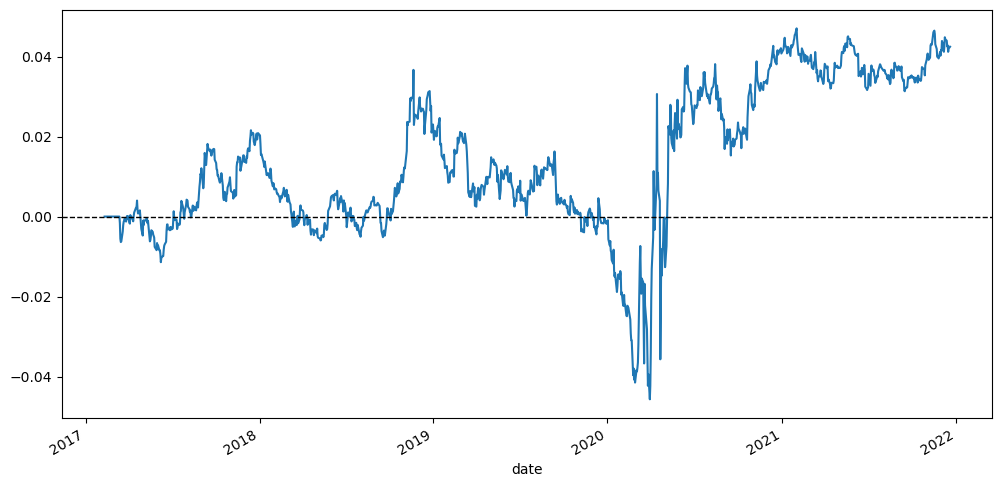

In [171]:
naive_ret.cumsum().plot(figsize=(12, 6))
plt.axhline(0, ls='--', lw=1, color='black')

#### Orthogonalize from PCA factors

In [172]:
eigenret_oos = _rets.loc[val_dates] @ eigen_port.T

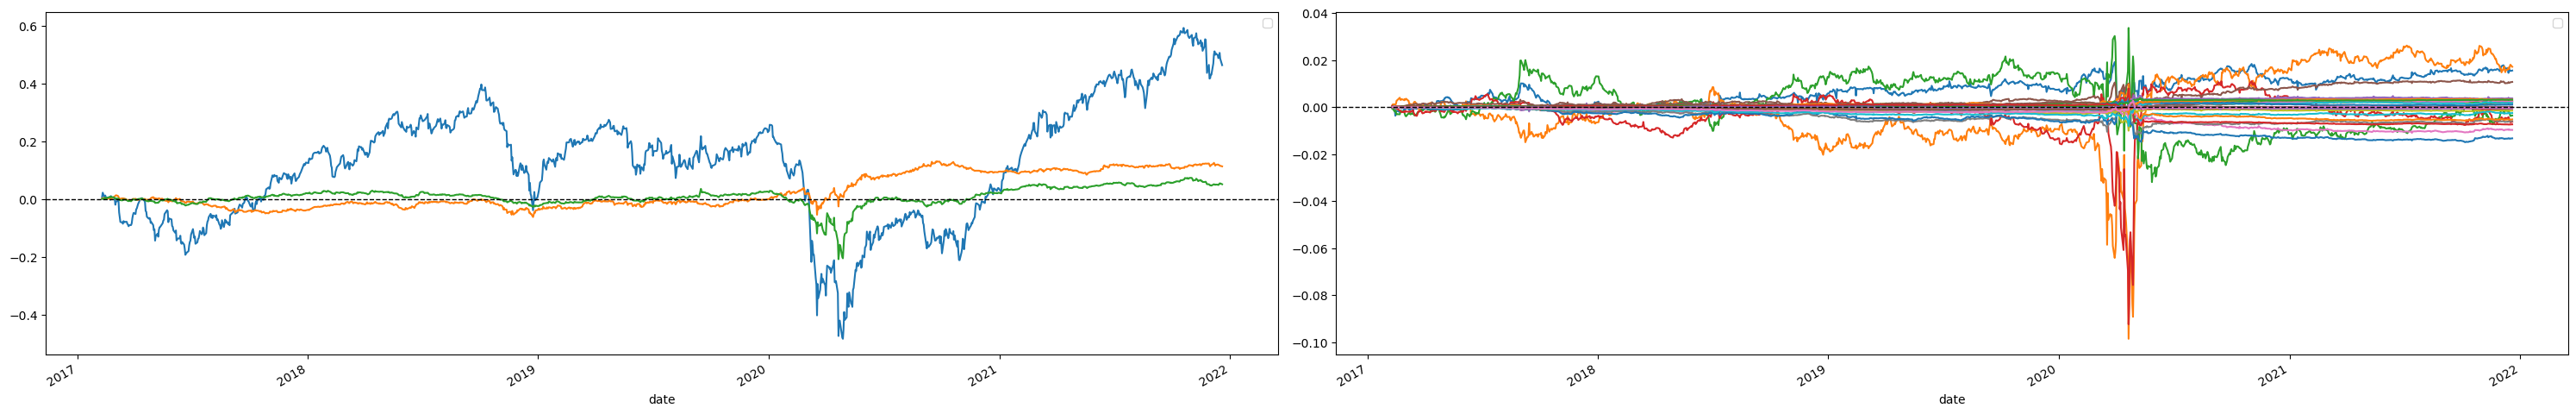

In [173]:
fig, axs = plt.subplots(1, 2, figsize=(30, 6))
eigenret_oos.iloc[:, :3].cumsum().plot(ax=axs[0], label='')
eigenret_oos.iloc[:, 3:].cumsum().plot(ax=axs[1], label='')
fig.tight_layout()
for ax in axs:
    ax.axhline(0, ls='--', lw=1, color='black')
    ax.legend([])
plt.show()

In [193]:
pos = (alpha_port > 0)
neg = (alpha_port < 0)
pos = alpha_port[pos].sum(1)
neg = alpha_port[neg].sum(1)

In [194]:
wgt_norm = wgt_raw.apply(
    lambda x: np.where(x > 0, x / pos, -x / neg)
)

In [195]:
rnc_ret = (wgt_norm.shift().dropna() * _rets.loc[val_dates[1:]]).sum(1)
rnc_ret_raw = (wgt_raw.shift().dropna() * _rets.loc[val_dates[1:]]).sum(1)

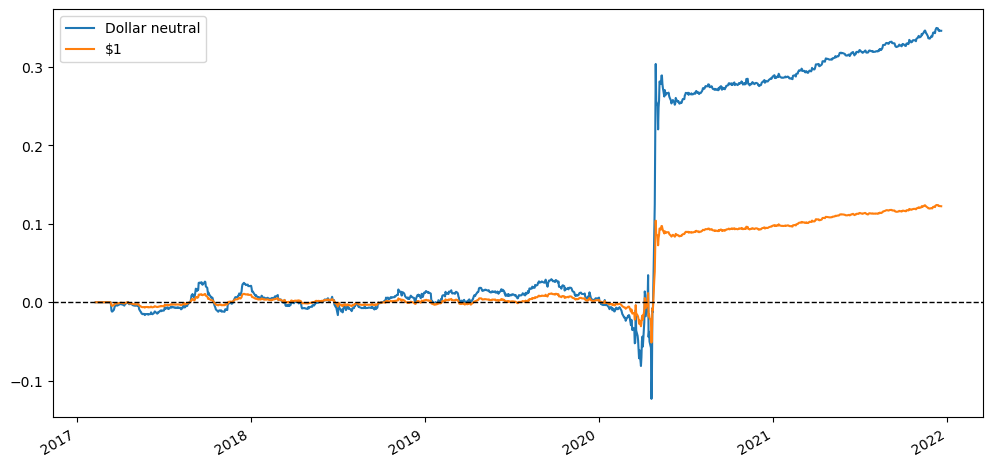

In [198]:
rnc_ret.cumsum().plot(figsize=(12, 6), label='Dollar neutral')
rnc_ret_raw.cumsum().plot(label='$1')
plt.legend()
plt.axhline(0, ls='--', lw=1, color='black')

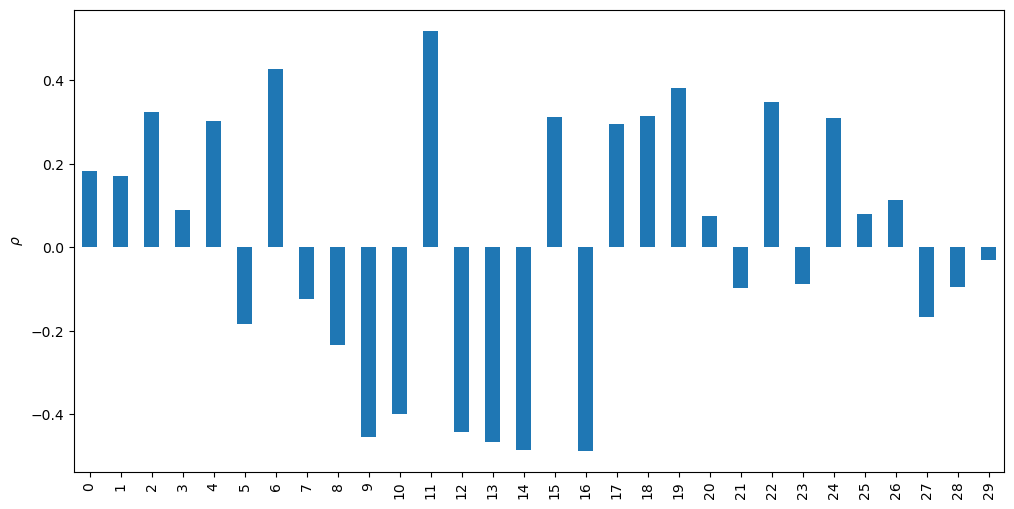

In [206]:
eigenret_oos.loc[rnc_ret_raw.index].corrwith(rnc_ret_raw).plot.bar(figsize=figsize)
plt.ylabel(r"$\rho$")
plt.show()

# Looking at the PCA noise portfolios

In [ ]:
# the eigen_rets are already computed with the train evecs
noise = eigen_rets.iloc[:, 10:].copy()#.to_frame()
noise = noise.sum(axis=1).to_frame()
noise.columns = ['noise']
noise['process'] = ((noise['noise'] + 1).cumprod() -1)
noise['process_ma'] = noise['process'].rolling(window=60, center=False).mean()

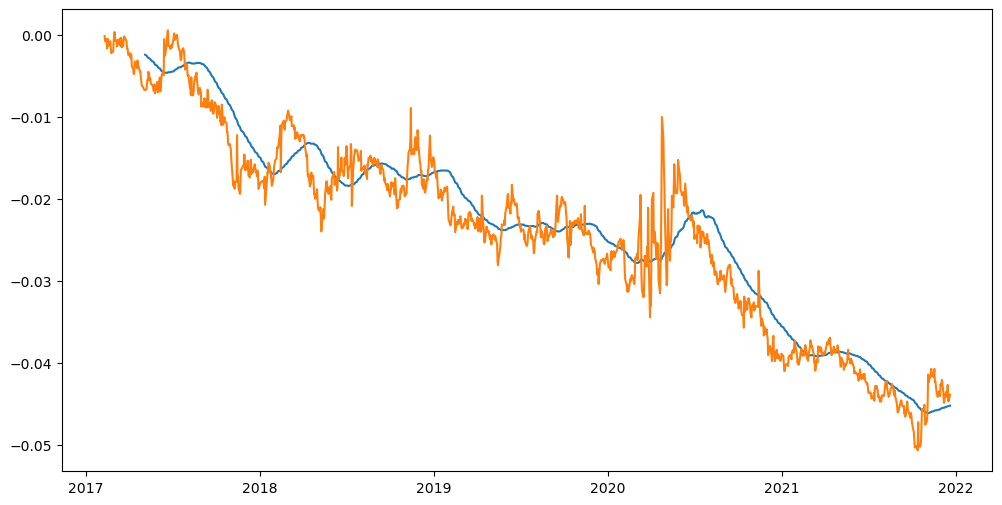

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(noise.index, noise['process_ma'])
plt.plot(noise.index, noise['process'])

In [ ]:
# now let's take a look of the portfolio without updating the parameters every 60 days

In [ ]:
pd.DataFrame(evecs[:, 10:]).sum(axis=1)

0     3.663000
1     1.768763
2    -0.712015
3     1.050745
4     0.896260
5    -0.809933
6    -0.024724
7     0.344059
8     0.044216
9     0.154044
10   -0.116713
11    0.014475
12   -0.184948
13    0.120248
14   -0.041564
15   -0.136777
16    0.034133
17    0.034960
18   -0.124831
19   -0.200733
20   -0.261541
21    0.061609
22    0.049469
23    0.010448
24   -0.016043
25    0.121398
26    0.047109
27    0.029474
28    0.069520
29   -0.007981
dtype: float64

<BarContainer object of 30 artists>

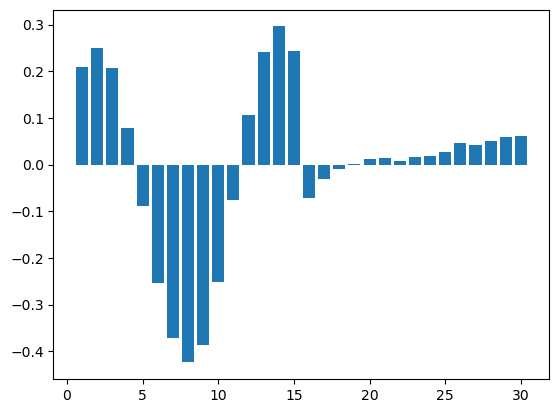

In [ ]:
plt.bar(np.arange(1, 31),evecs[3])

In [ ]:
# This plot it's what happens that i long the residuals continuosly. So what I want to do is trade this beavior 

<Axes: xlabel='date'>

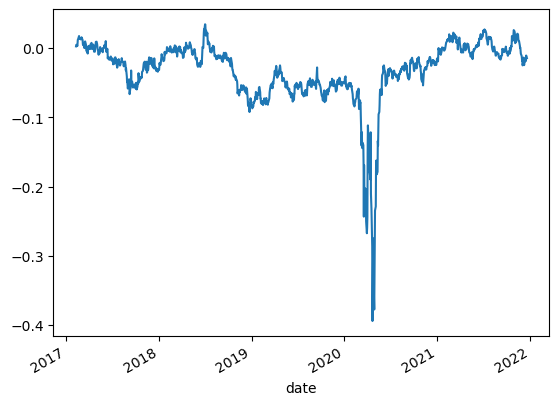

In [ ]:
((1+eigen_rets.iloc[:, 4]).cumprod()-1).plot()

In [46]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [47]:
r2 = pd.DataFrame(r2_score(y_val, y_hat, multioutput='raw_values'), index=range(n_assets))
mse = pd.DataFrame(mean_squared_error(y_val, y_hat, multioutput='raw_values'), index=range(n_assets))
mae = pd.DataFrame(mean_absolute_error(y_val, y_hat, multioutput='raw_values'), index=range(n_assets))

In [48]:
(np.sign(y_val) == np.sign(y_hat)).mean()

0     0.514523
1     0.521992
2     0.512863
3     0.517842
4     0.541079
5     0.537759
6     0.539419
7     0.539419
8     0.524481
9     0.512863
10    0.512863
11    0.530290
12    0.519502
13    0.531120
14    0.511203
15    0.510373
16    0.515353
17    0.519502
18    0.500415
19    0.521162
20    0.509544
21    0.497925
22    0.508714
23    0.490456
24    0.506224
25    0.515353
26    0.501245
27    0.505394
28    0.519502
29    0.497095
dtype: float64

In [49]:
(y_hat > 0).mean()

0     0.854772
1     0.606639
2     0.535270
3     0.582573
4     0.496266
5     0.372614
6     0.350207
7     0.297925
8     0.448963
9     0.593361
10    0.604979
11    0.314523
12    0.482158
13    0.298755
14    0.241494
15    0.479668
16    0.490456
17    0.229876
18    0.318672
19    0.115353
20    0.147718
21    0.097925
22    0.258921
23    0.146888
24    0.213278
25    0.326971
26    0.173444
27    0.314523
28    0.392531
29    0.609129
dtype: float64

In [50]:
(y_val > 0).mean()

0     0.521992
1     0.530290
2     0.536100
3     0.507054
4     0.495436
5     0.481328
6     0.495436
7     0.482988
8     0.486307
9     0.476349
10    0.479668
11    0.483817
12    0.486307
13    0.502075
14    0.494606
15    0.456432
16    0.465560
17    0.489627
18    0.502905
19    0.509544
20    0.523651
21    0.530290
22    0.532780
23    0.543568
24    0.531120
25    0.517842
26    0.522822
27    0.510373
28    0.502905
29    0.492946
dtype: float64

<Axes: >

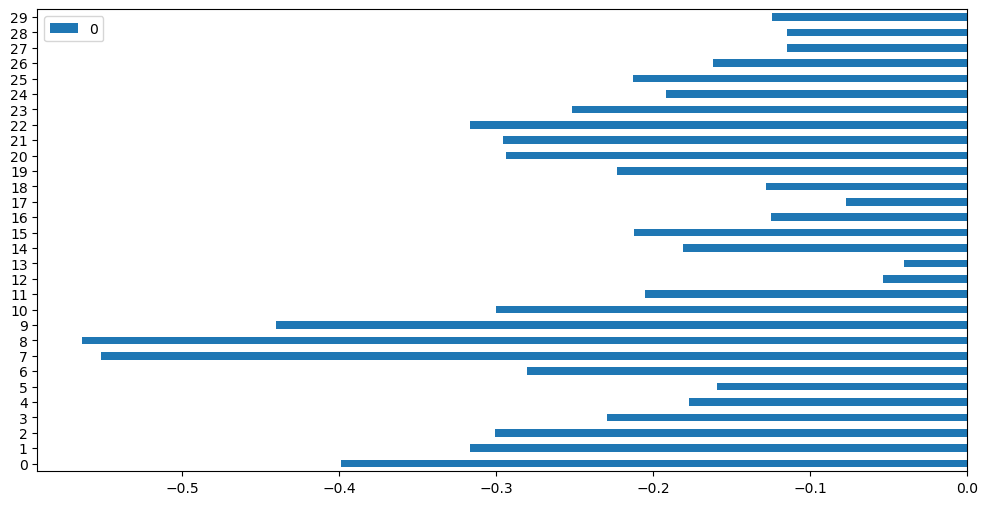

In [51]:
r2.plot.barh(figsize=(12, 6))

<Axes: >

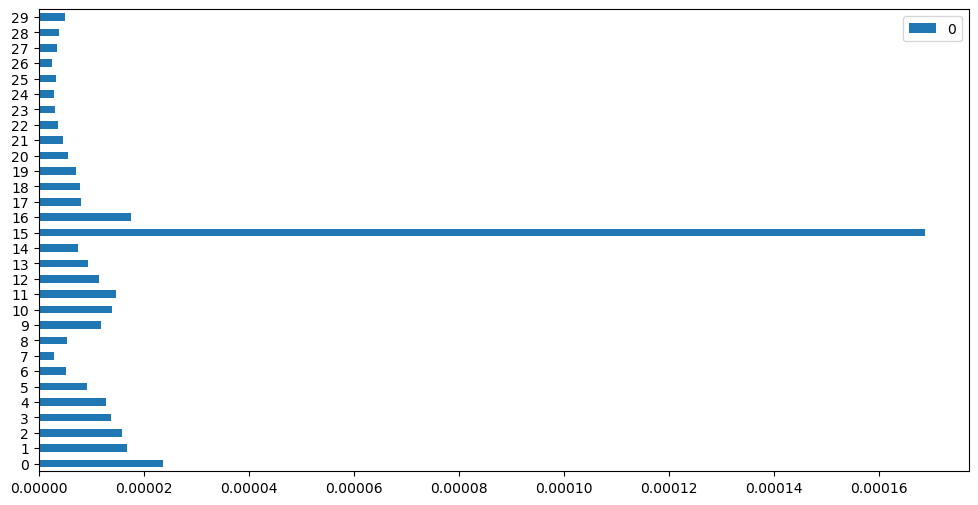

In [52]:
mse.plot.barh(figsize=(12, 6))

<Axes: >

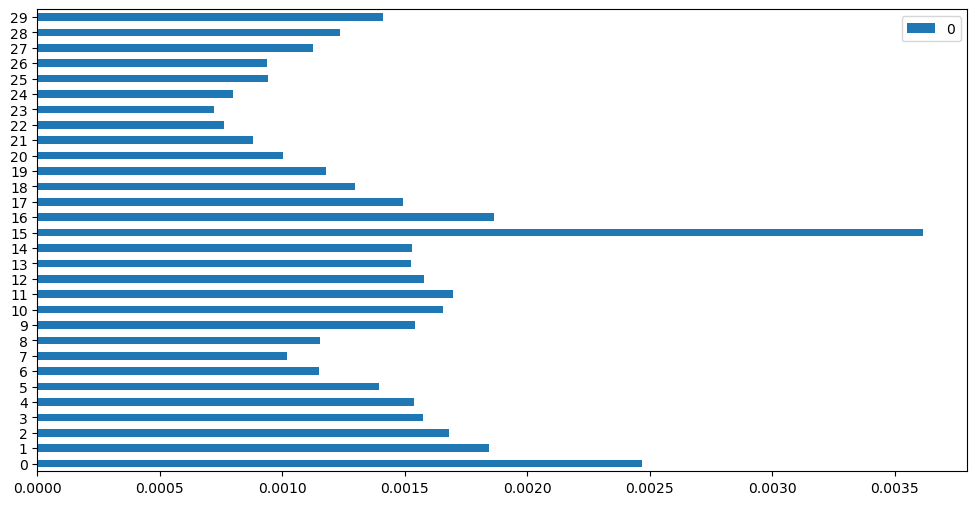

In [53]:
mae.plot.barh(figsize=(12, 6))

# Lunga Memoria a Breve Termine

(meglio nota come LMBT)

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [28]:
n_assets = rets.shape[1]

In [29]:
_, resid = get_fitted_and_residuali(3)

In [30]:
# Assuming df is your DataFrame
data = resid.values

lag = 10  # Number of past time steps to use
X, y = [], []

for i in range(lag, len(data)):
    X.append(data[i - lag:i, :])
    y.append(data[i, :])

X = np.array(X)
y = np.array(y)

In [46]:
model = Sequential()
model.add(LSTM(32, input_shape=(lag, n_assets)))
model.add(Dense(n_assets))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X, y, epochs=1_000, batch_size=32, verbose=0)

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [63]:
corr = rets.corr()

In [64]:
evals, evecs = np.linalg.eig(corr)
evecs = evecs.T

idx = np.argsort(evals)[::-1]
evals, evecs = evals[idx], evecs[idx]

In [65]:
n_factors = 3
factors = np.arange(n_factors)

In [71]:
# Assuming df is your DataFrame
data = resid.values

lag = 5  # Number of past time steps to use
X, y = [], []

for i in range(lag, len(data)):
    X.append(data[i - lag:i, :])
    y.append(data[i, :])

X = np.array(X)
y = np.array(y)

In [72]:
y_hat = model.predict(X)

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step


In [73]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [74]:
r2 = pd.DataFrame(r2_score(y, y_hat, multioutput='raw_values'), index=range(n_assets))
mse = pd.DataFrame(mean_squared_error(y, y_hat, multioutput='raw_values'), index=range(n_assets))
mae = pd.DataFrame(mean_absolute_error(y, y_hat, multioutput='raw_values'), index=range(n_assets))

In [81]:
(np.sign(y) == np.sign(y_hat)).mean()

0.524051324051324

In [84]:
(y_hat > 0).mean()

0.5427791427791427

In [85]:
(y > 0).mean()

0.5031395031395032

<Axes: >

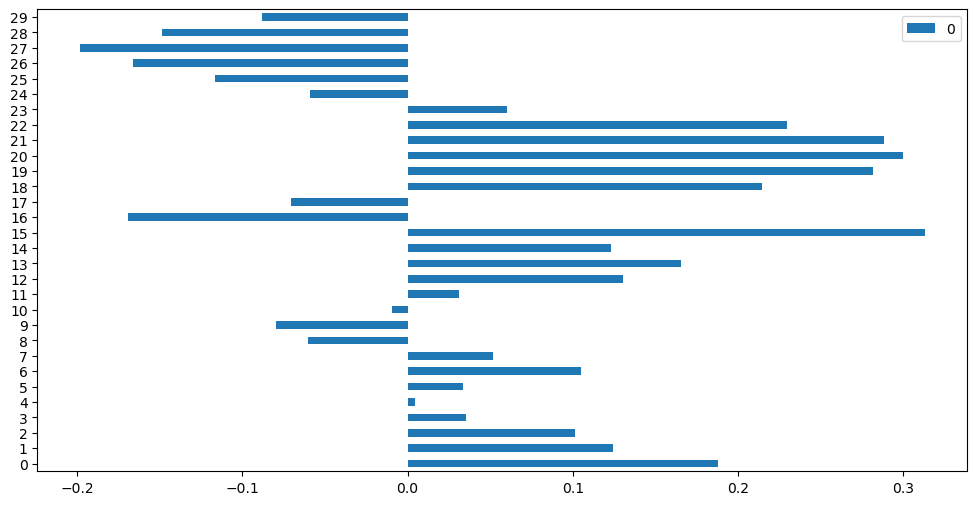

In [75]:
r2.plot.barh(figsize=(12, 6))

<Axes: >

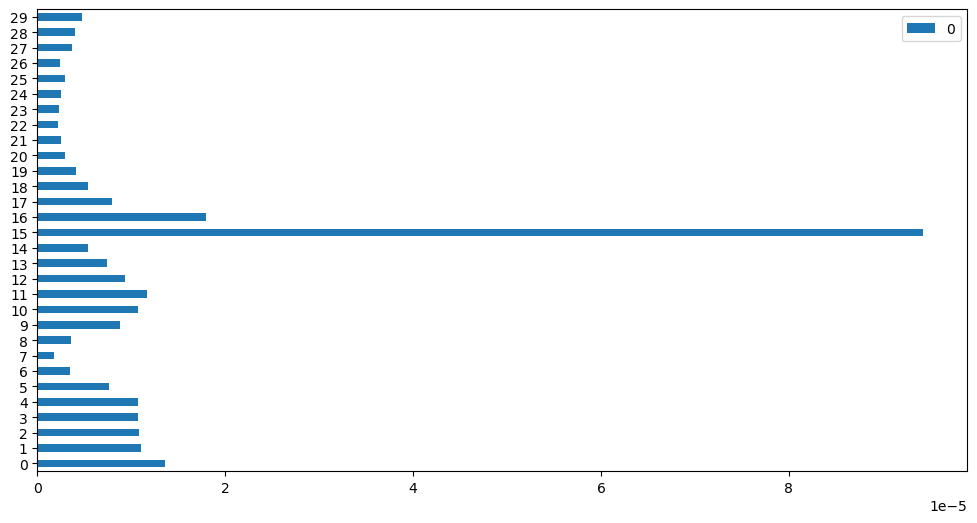

In [76]:
mse.plot.barh(figsize=(12, 6))

<Axes: >

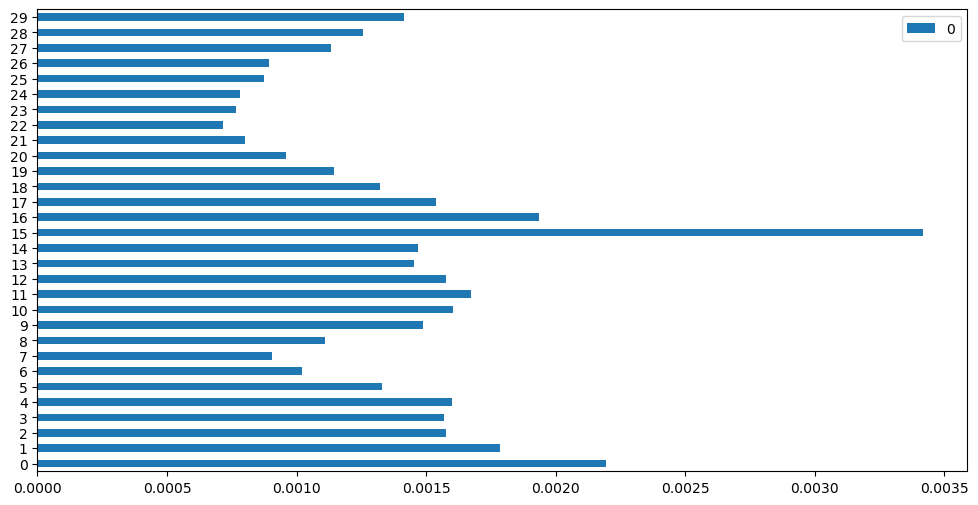

In [77]:
mae.plot.barh(figsize=(12, 6))